# Intelligence Report: Exploratory Data Analysis (Active Environment)
**Project:** Orbital Clutter: Mapping the Kessler Acceleration  
**Dataset:** `ucs_cleaned.csv` (Active Satellite Population)  
**Analyst:** James Glosser  

---

### **The Analytical Strategy**
Before modeling the collision probability of the debris field, we must establish a baseline of the **Active Population**. This notebook characterizes the "Target Environment" across three dimensions:

1.  **Mass Profiling:** Identifying "High-Value" targets versus the swarm (Starlink/CubeSats) to understand kinetic potential.
2.  **Stakeholder Analysis:** Quantifying the shift from State-Actor dominance to Commercial proliferation.
3.  **Temporal Dynamics:** Modeling the velocity of "New Space" launches to determine the acceleration rate.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from scipy.optimize import curve_fit, brentq

# Set the Palette (High Contrast Neon)
sns.set_palette("plasma") 

# Set the Background (Deep Space Black)
plt.style.use('dark_background')

# Force Overrides for "True Black" and readability
plt.rcParams.update({
    "grid.alpha": 0.2,            # Faint, non-intrusive grid
    "axes.facecolor": "black",    # No grey haze in plot area
    "figure.facecolor": "black",  # No grey haze in outer area
    "text.color": "white",        # High contrast text
    "axes.labelcolor": "white",   # Axis labels
    "xtick.color": "white",       # Ticks
    "ytick.color": "white",
    "legend.facecolor": "black",  # Legend background
    "legend.edgecolor": "white"   # Legend border
})

print("Environment Initialized: Visual Systems Online.")

Environment Initialized: Visual Systems Online.


### Data Pre-Processing: Feature Engineering
**Objective:** Standardize categorical features for aggregation.
* **Orbit Regimes:** Compressing sub-classes into the "Big Three" (`LEO`, `MEO`, `GEO`) to map the Kessler Canyon.

In [2]:
# Load Data & Parse Dates
# We parse dates immediately to enable the Temporal Analysis later
ucs_cleaned = pd.read_csv('../data/clean/ucs_cleaned.csv', parse_dates=['launch_date'])

# Redundant safety conversion to ensure mixed formats don't crash the timeline
ucs_cleaned['launch_date'] = pd.to_datetime(ucs_cleaned['launch_date'], errors='coerce')
ucs_cleaned['launch_year'] = ucs_cleaned['launch_date'].dt.year

# Regime Standardization
# We map the complex registry into the "Big Three" risk zones.
# Anything that isn't LEO, MEO, or GEO gets tagged as "Other".
target_orbits = ['LEO', 'MEO', 'GEO']

# We use str.upper() to catch 'Leo' or 'geo' typos, just to be safe
ucs_cleaned['orbit_regime'] = ucs_cleaned['orbit_class'].apply(
    lambda x: x if str(x).upper() in target_orbits else 'Other'
)

# GLOBAL DATA PATCHES
# Unify variations of "SpaceX" so the Oligopoly analysis is accurate
if 'owner' in ucs_cleaned.columns:
    ucs_cleaned['owner'] = ucs_cleaned['owner'].replace({
        'Spacex': 'SpaceX',
        'spacex': 'SpaceX',
        'spaceX': 'SpaceX',
        'Swarm Technologies': 'SpaceX',
        'Space Exploration Technologies Corp.': 'SpaceX'
    })

# Mission Status Check
print("--- SYSTEM INITIALIZED ---")
print(f"Active Fleet Registry:   {len(ucs_cleaned):,} operational assets validated.")
print(f"Data Schema:             {ucs_cleaned.shape[1]} features available.")
print(f"Regime Distribution:     {ucs_cleaned['orbit_regime'].value_counts().to_dict()}")
print(f"Time Horizon:            {int(ucs_cleaned['launch_year'].min())} - {int(ucs_cleaned['launch_year'].max())}")

--- SYSTEM INITIALIZED ---
Active Fleet Registry:   7,542 operational assets validated.
Data Schema:             35 features available.
Regime Distribution:     {'LEO': 6750, 'GEO': 590, 'MEO': 143, 'Other': 59}
Time Horizon:            1974 - 2023


## Section 1.0: Kinetic Mass Profiling
**The Objective:** Visualize the distribution of mass in orbit. In a collision event, mass equates to "shrapnel potential." We must distinguish between the "Swarm" (low mass, high count) and the "Heavy Hitters" (high mass, low count).

**The Methodology:**
* **Logarithmic Scaling:** Applied to `launch_mass_kg` to account for the disparity between CubeSats (<10 kg) and the **International Space Station (450,000 kg)**.
* **White Whale Logic:** Explicitly handling the ISS outlier to prevent visualization compression.

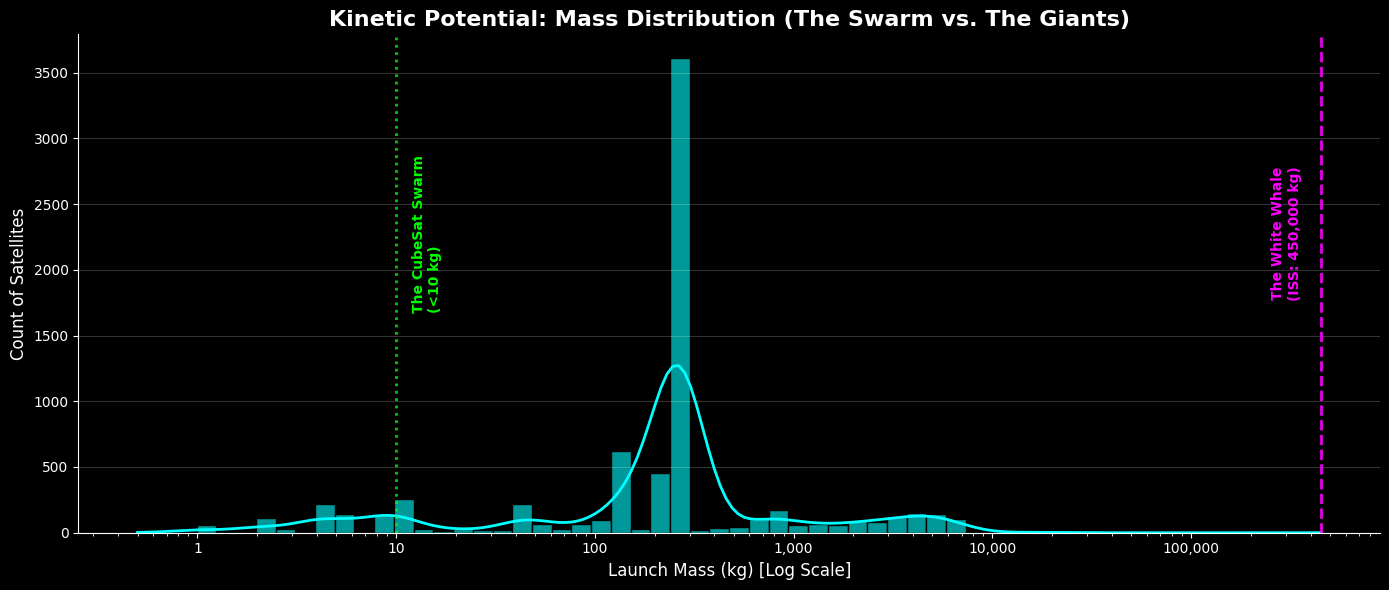

--- Mass Profile Statistics (kg) ---
count      7542.000000
mean        690.291627
std        5358.470789
min           0.500000
25%         148.000000
50%         260.000000
75%         280.000000
max      450000.000000
Name: launch_mass_kg, dtype: object


In [3]:
plt.figure(figsize=(14, 6))

sns.histplot(ucs_cleaned['launch_mass_kg'], kde=True, bins=60, log_scale=True, 
             color='cyan', edgecolor='black', alpha=0.6, line_kws={'linewidth': 2})

ax = plt.gca()
y_min, y_max = ax.get_ylim()

# The CubeSat Swarm (<10 kg)
plt.axvline(x=10, color='lime', linestyle=':', linewidth=2, alpha=0.8)
plt.text(12, y_max * 0.6, "The CubeSat Swarm\n(<10 kg)", 
         color='lime', rotation=90, fontweight='bold', va='center')

# The "White Whale" (ISS) -> FIXED
iss_mass = 450000
plt.axvline(iss_mass, color='magenta', linestyle='--', linewidth=2, alpha=0.9)

plt.text(iss_mass * 0.8, y_max * 0.6, f'The White Whale\n(ISS: {iss_mass:,} kg)', 
         color='magenta', rotation=90, ha='right', fontweight='bold', va='center')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Kinetic Potential: Mass Distribution (The Swarm vs. The Giants)', fontsize=16, color='white', fontweight='bold')
plt.xlabel('Launch Mass (kg) [Log Scale]', fontsize=12, color='white')
plt.ylabel('Count of Satellites', fontsize=12, color='white')
plt.grid(axis='y', alpha=0.2)

sns.despine()
plt.tight_layout()
plt.savefig('../images/mass_distribution_log.png', dpi=300, bbox_inches='tight')
plt.show()

print("--- Mass Profile Statistics (kg) ---")
print(ucs_cleaned['launch_mass_kg'].describe().apply(lambda x: format(x, 'f')))

## Section 1.5: Orbital Topography (The Kessler Canyon)
**The Objective:** Map the physical distribution of assets to identify the "Kessler Canyon"—the altitude bands with the highest density of collision targets.

**The Insight:**
Mass is not evenly distributed. The **Scatter Analysis** below reveals that the "Swarm" (low mass) is concentrating in Low Earth Orbit (LEO), while legacy heavy platforms dominate Geosynchronous Orbit (GEO).

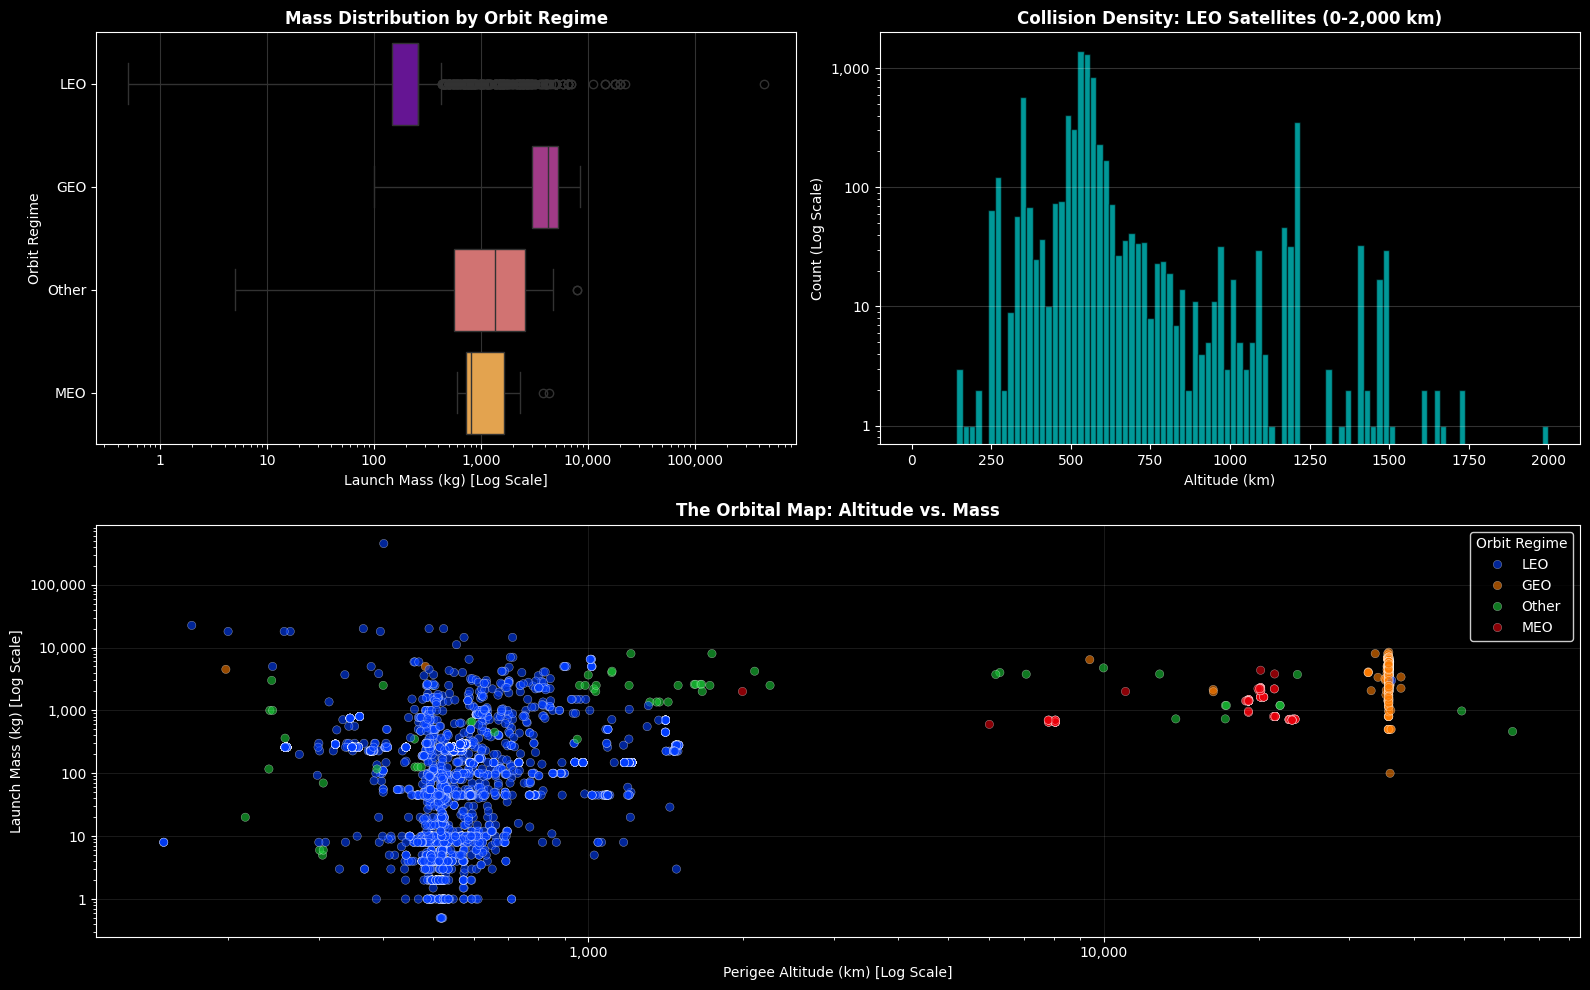

In [4]:
plt.figure(figsize=(16, 10))

# Plot A: Mass vs. Orbit Regime (The Weight of Regimes)
plt.subplot(2, 2, 1)
sns.boxplot(data=ucs_cleaned, x='launch_mass_kg', y='orbit_regime', hue='orbit_regime', palette='plasma', legend=False)
plt.xscale('log')

# Formatting the Axis to be easier to read. Average people can't visualize/conceptualize what 10(^n) represents.
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Mass Distribution by Orbit Regime', color='white', fontweight='bold')
plt.xlabel('Launch Mass (kg) [Log Scale]', color='white')
plt.ylabel('Orbit Regime', color='white')
plt.grid(axis='x', alpha=0.2)


# Plot B: The Kessler Canyon (Altitude Density)
plt.subplot(2, 2, 2)

# We limit to 2,000km to focus on the LEO congestion point
plt.hist(ucs_cleaned['perigee_km'], bins=100, range=(0, 2000), color='cyan', alpha=0.6, edgecolor='black')
plt.yscale('log')

# Format Y-axis to standard numbers
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Collision Density: LEO Satellites (0-2,000 km)', color='white', fontweight='bold')
plt.xlabel('Altitude (km)', color='white')
plt.ylabel('Count (Log Scale)', color='white')
plt.grid(axis='y', alpha=0.2)


# Plot C: The Orbital Map (Altitude vs. Mass)
plt.subplot(2, 1, 2)
sns.scatterplot(data=ucs_cleaned, x='perigee_km', y='launch_mass_kg', hue='orbit_regime', 
                palette='bright', alpha=0.6, edgecolor='white', linewidth=0.3)
plt.yscale('log')
plt.xscale('log')

# Format BOTH axes to standard numbers for maximum readability
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('The Orbital Map: Altitude vs. Mass', color='white', fontweight='bold')
plt.xlabel('Perigee Altitude (km) [Log Scale]', color='white')
plt.ylabel('Launch Mass (kg) [Log Scale]', color='white')
plt.grid(True, alpha=0.1)
plt.legend(title='Orbit Regime', facecolor='black', edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

## Section 2.0: Stakeholder Architecture
**The Objective:** Quantify the shift from State-Actor dominance to Commercial proliferation.

**The Transition:**
* **Old Space (Pre-2012):** A domain reserved for superpowers (USA, Russia, China).
* **New Space (Post-2012):** The explosion of commercial entities. The visualizations below highlight this inversion of control.

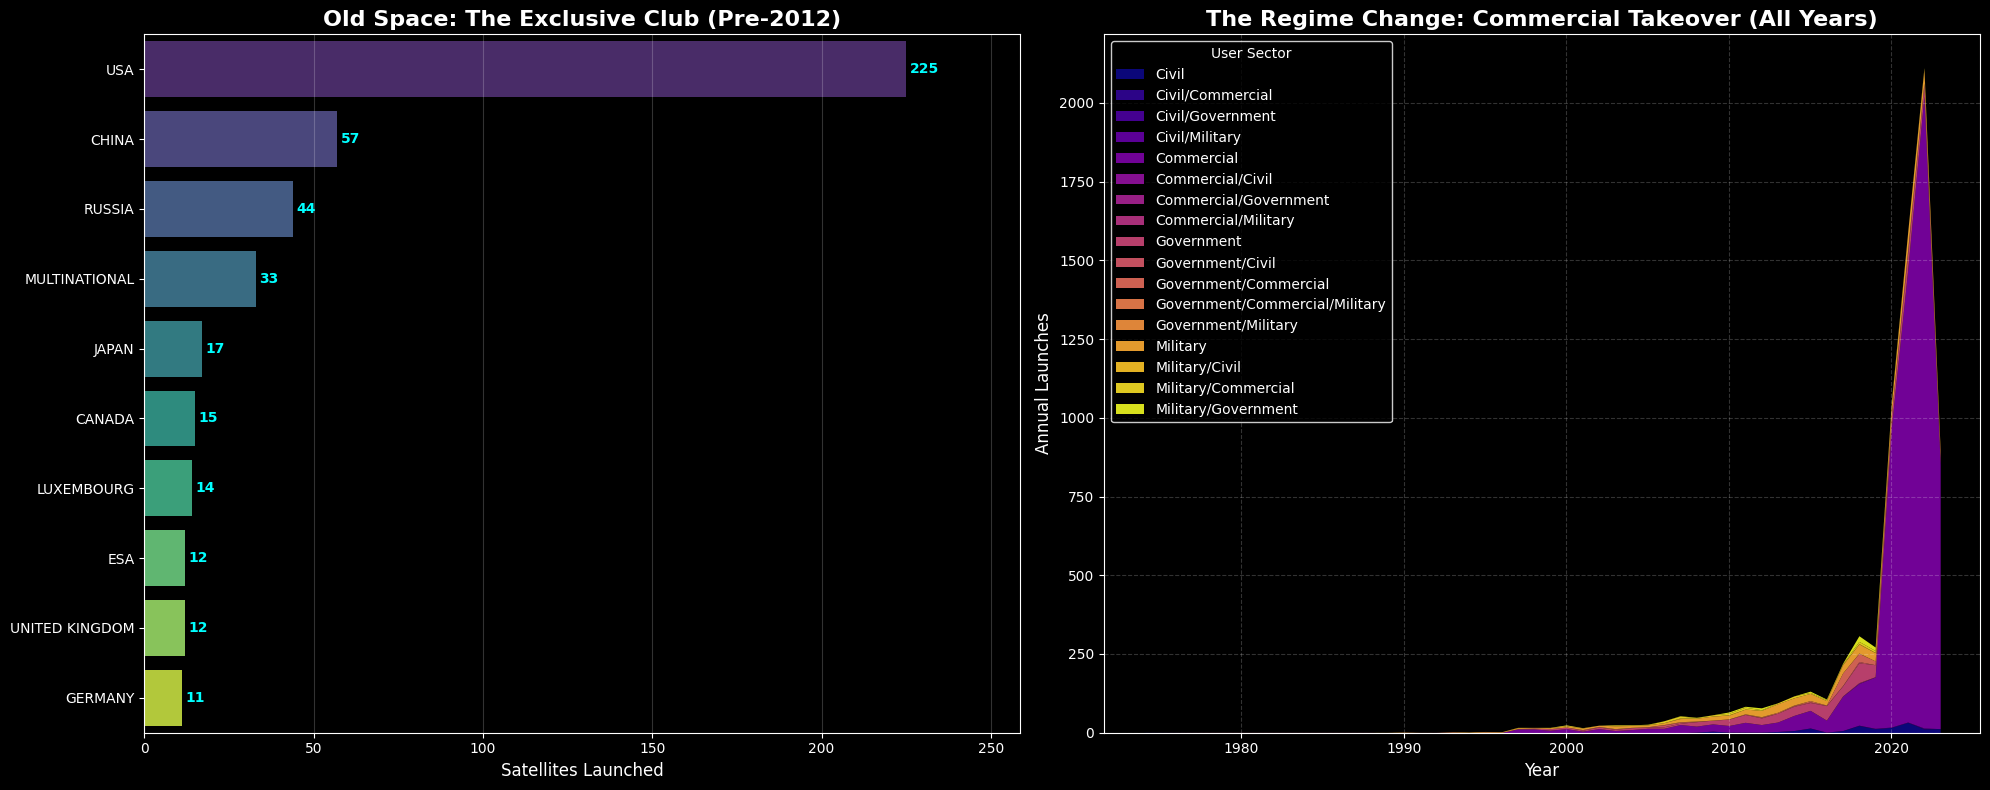

In [5]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)

old_space = ucs_cleaned[ucs_cleaned['launch_year'] < 2012]

country_counts = old_space['country_operator'].value_counts().head(10)

sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, 
            palette='viridis', legend=False)

plt.title('Old Space: The Exclusive Club (Pre-2012)', fontsize=16, color='white', fontweight='bold')
plt.xlabel('Satellites Launched', fontsize=12, color='white')
plt.ylabel('')
plt.grid(axis='x', alpha=0.2)

for i, v in enumerate(country_counts.values):
    plt.text(v + 1, i, str(v), color='cyan', va='center', fontweight='bold', fontsize=10)

plt.xlim(0, country_counts.max() * 1.15)

plt.subplot(1, 2, 2)

sat_counts = ucs_cleaned.pivot_table(index='launch_year', columns='users', values='norad_id', aggfunc='count').fillna(0)

sat_counts.plot(kind='area', stacked=True, ax=plt.gca(), cmap='plasma', alpha=0.9, linewidth=0)

plt.title('The Regime Change: Commercial Takeover (All Years)', fontsize=16, color='white', fontweight='bold')
plt.ylabel('Annual Launches', fontsize=12, color='white')
plt.xlabel('Year', fontsize=12, color='white')
plt.grid(True, linestyle='--', alpha=0.2)

plt.legend(title='User Sector', facecolor='black', edgecolor='white', labelcolor='white', loc='upper left')

plt.tight_layout()
plt.show()

## Section 2.5: The Oligopoly of Orbit
**The Objective:** Identify the specific entities driving the commercial surge.

**The Insight:**
While "Commercial" is the category, the volume is not evenly distributed. The **Operator Dominance** chart below reveals that the Low Earth Orbit environment is becoming a de facto monopoly, with a single provider accounting for a disproportionate share of the active collision cross-section.

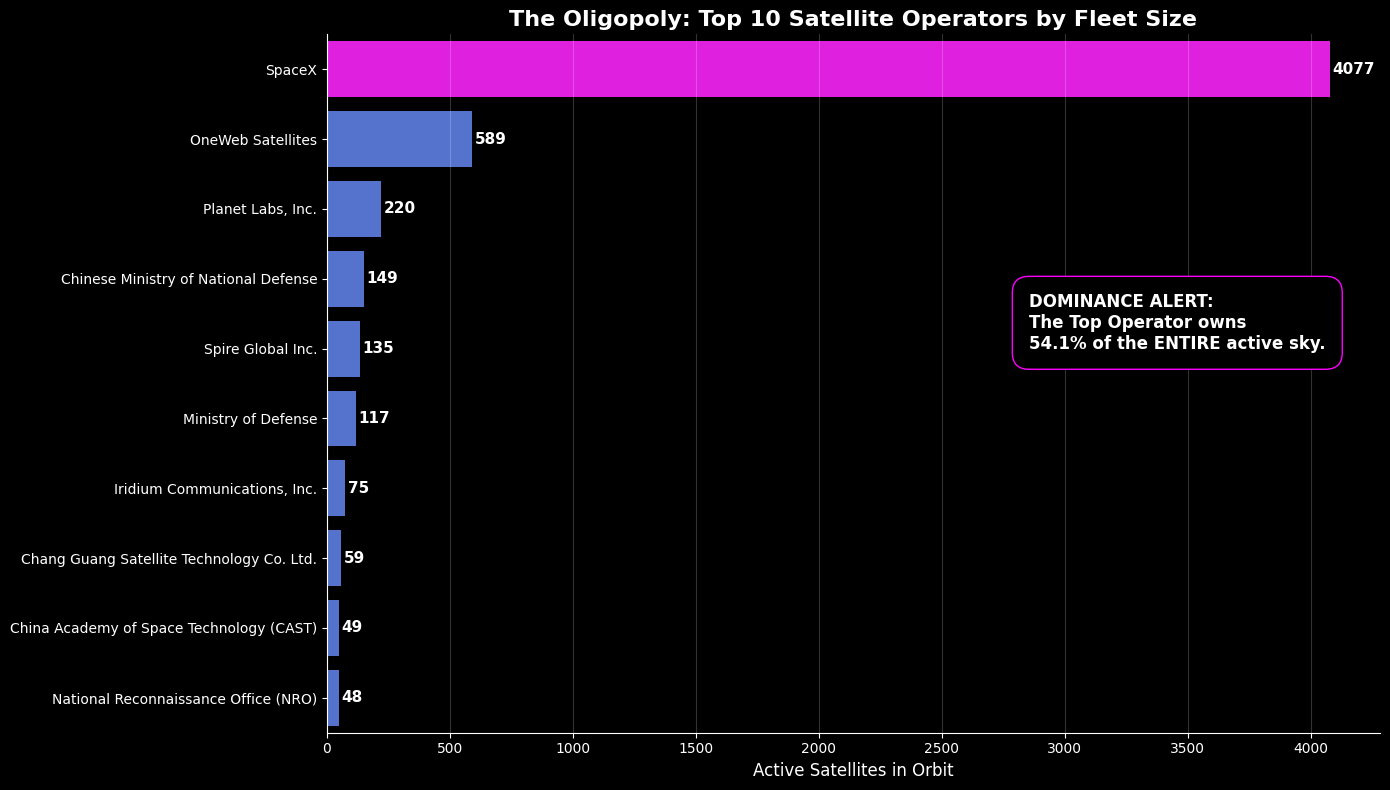

In [6]:

# Get the Top 10 Owners
top_operators = ucs_cleaned['owner'].value_counts().head(10)

plt.figure(figsize=(14, 8))

# Create the Bar Chart
# Using Magenta for the top owner and cool colors for everyone else helps emphasize the disparity and create contrast for visibility.
clrs = ['magenta' if (x == top_operators.max()) else 'royalblue' for x in top_operators.values]

sns.barplot(x=top_operators.values, y=top_operators.index, hue=top_operators.index, palette=clrs, legend=False)

# Annotation and Formatting
plt.title('The Oligopoly: Top 10 Satellite Operators by Fleet Size', fontsize=16, color='white', fontweight='bold')
plt.xlabel('Active Satellites in Orbit', fontsize=12, color='white')
plt.ylabel('', color='white')

# Add the counts to the end of the bars
for i, v in enumerate(top_operators.values):
    plt.text(v + 10, i, str(v), color='white', va='center', fontweight='bold', fontsize=11)

# The "Concentration" Metric
total_sats = len(ucs_cleaned)
top_1_share = (top_operators.values[0] / total_sats) * 100

plt.text(top_operators.values[0] * 0.7, 4, 
         f"DOMINANCE ALERT:\nThe Top Operator owns\n{top_1_share:.1f}% of the ENTIRE active sky.", 
         fontsize=12, color='white', fontweight='bold',
         bbox=dict(facecolor='black', edgecolor='magenta', boxstyle='round,pad=1'))

plt.grid(axis='x', alpha=0.2)
sns.despine()

plt.tight_layout()
plt.savefig('../images/operator_oligopoly.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 2.6: Geospatial Topography (The Hegemony Shift)
**The Objective:** Map the physical control of orbital space.

**The Comparison:**
* **Early Space (Pre-2012):** A bipolar domain shared by the USA and Russia (Soviet Legacy).
* **The 2026 Simulation:** A unipolar domain dominated by US-based commercial entities.

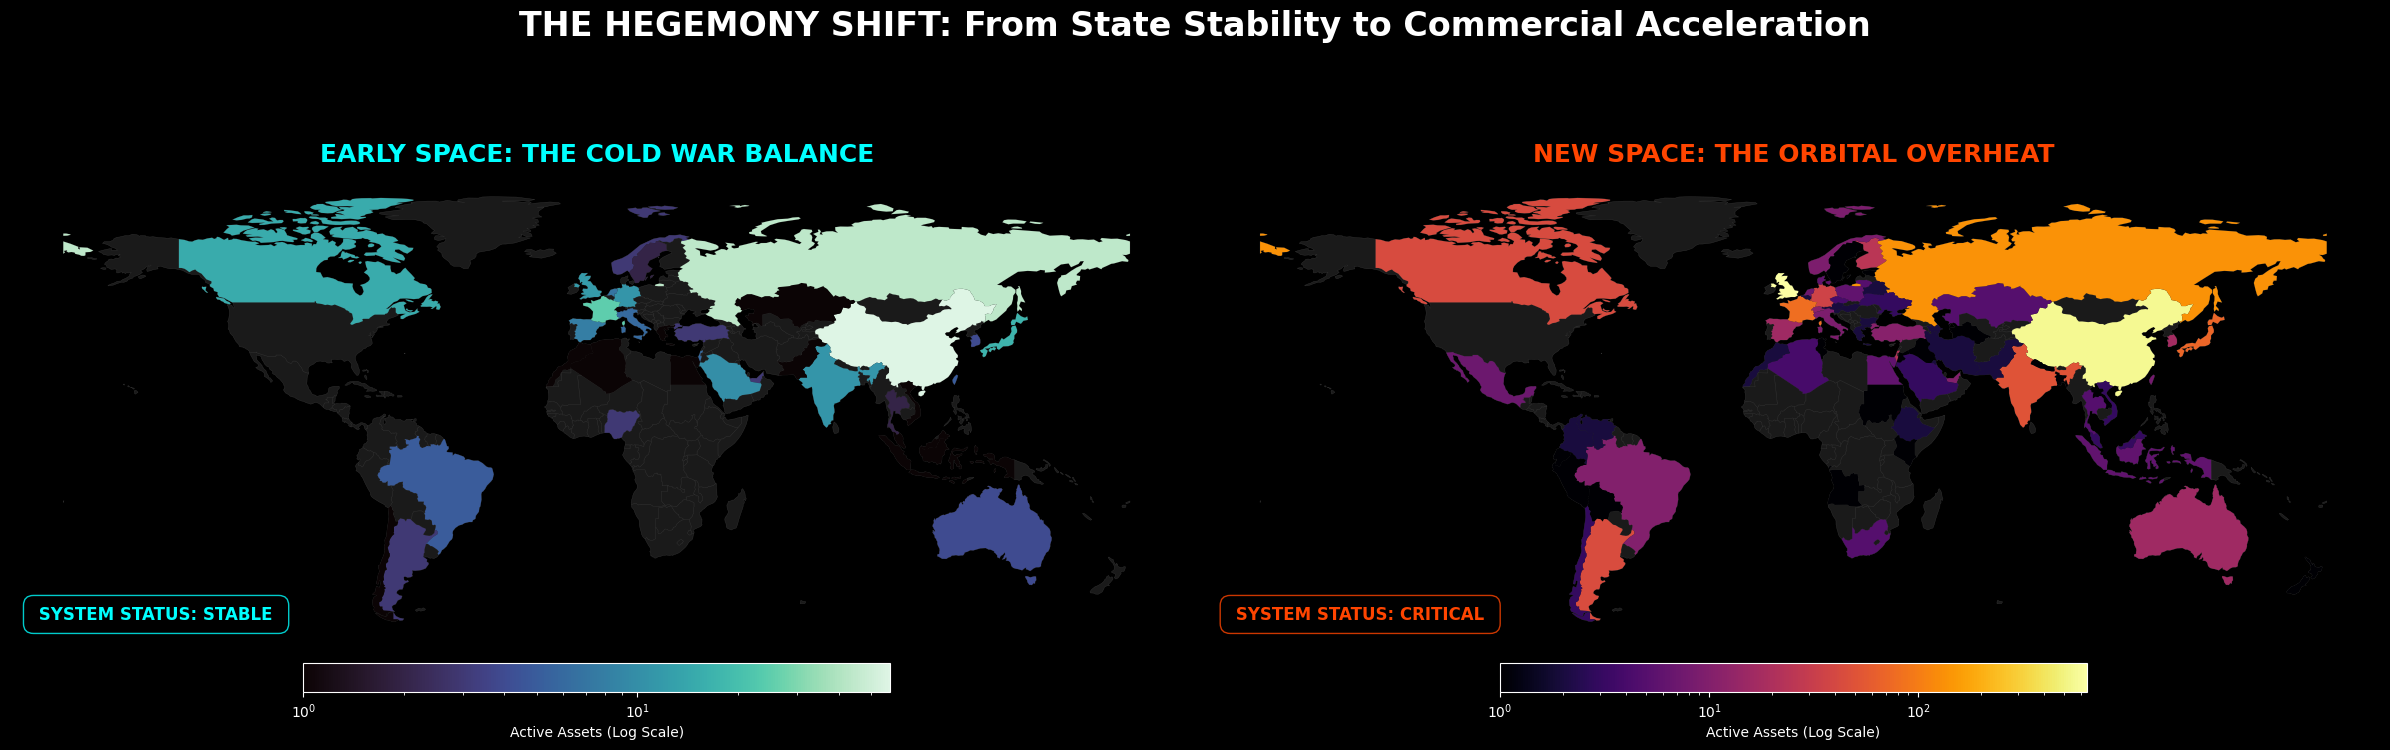

In [7]:
try:
    world = gpd.read_file('../data/original/countries.geojson')
    world = world[(world.name != "Antarctica")]
except Exception as e:
    world = pd.DataFrame({'name': [], 'geometry': []})

def standardize_country(name):
    clean_name = str(name).split('/')[0].strip().title()

    mapping = {
        'United States Of America': 'United States', 'Usa': 'United States', 'United States': 'United States',
        'Uk': 'United Kingdom', 'Great Britain': 'United Kingdom',
        'Soviet Union': 'Russia', 'Prc': 'China', 'People\'s Republic Of China': 'China',
        'Korea': 'South Korea', 'Republic Of Korea': 'South Korea', 'North Korea': 'Dem. Rep. Korea', 'Dprk': 'Dem. Rep. Korea',
        'Uae': 'United Arab Emirates', 'Saudi Arabia': 'Saudi Arabia',
        'Esa': 'France', 'European Space Agency': 'France'    
    }

    return mapping.get(clean_name, clean_name)

ucs_cleaned['geo_country'] = ucs_cleaned['country_operator'].apply(standardize_country)

early_space = ucs_cleaned[ucs_cleaned['launch_year'] < 2012]
new_space = ucs_cleaned[ucs_cleaned['launch_year'] >= 2012]

map_early = world.merge(early_space['geo_country'].value_counts().rename('sat_count'), 
                        left_on='name', right_index=True, how='left')
map_early['sat_count'] = map_early['sat_count'].fillna(0)

map_new = world.merge(new_space['geo_country'].value_counts().rename('sat_count'), 
                      left_on='name', right_index=True, how='left')
map_new['sat_count'] = map_new['sat_count'].fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

base_color = '#1A1A1A'
border_color = '#333333'

# Map A - Ice Theme
world.plot(ax=ax1, color=base_color, edgecolor=border_color, linewidth=0.3)
map_early[map_early['sat_count'] > 0].plot(
    column='sat_count', ax=ax1, cmap='mako', legend=True,
    norm=colors.LogNorm(vmin=1, vmax=map_early['sat_count'].max()),
    legend_kwds={'label': "Active Assets (Log Scale)", 'orientation': "horizontal", 'shrink': 0.5, 'pad': 0.03}
)
ax1.set_title('EARLY SPACE: THE COLD WAR BALANCE', fontsize=18, color='cyan', fontweight='bold', pad=10)
ax1.axis('off')

ax1.text(0.02, 0.05, " SYSTEM STATUS: STABLE ", transform=ax1.transAxes,
         fontsize=12, color='cyan', fontweight='bold',
         bbox=dict(facecolor='black', edgecolor='cyan', boxstyle='round,pad=0.6', alpha=0.8))

# Map B - Fire Theme
world.plot(ax=ax2, color=base_color, edgecolor=border_color, linewidth=0.3)
map_new[map_new['sat_count'] > 0].plot(
    column='sat_count', ax=ax2, cmap='inferno', legend=True,
    norm=colors.LogNorm(vmin=1, vmax=map_new['sat_count'].max()),
    legend_kwds={'label': "Active Assets (Log Scale)", 'orientation': "horizontal", 'shrink': 0.5, 'pad': 0.03}
)
ax2.set_title('NEW SPACE: THE ORBITAL OVERHEAT', fontsize=18, color='#FF4500', fontweight='bold', pad=10)
ax2.axis('off')

ax2.text(0.02, 0.05, " SYSTEM STATUS: CRITICAL ", transform=ax2.transAxes,
         fontsize=12, color='#FF4500', fontweight='bold',
         bbox=dict(facecolor='black', edgecolor='#FF4500', boxstyle='round,pad=0.6', alpha=0.8))

plt.suptitle('THE HEGEMONY SHIFT: From State Stability to Commercial Acceleration', 
             fontsize=24, color='white', fontweight='bold', y=0.96)

# 'tight_layout' with rect pulls the content up to fill the void
plt.tight_layout(rect=[0, 0, 1, 0.93])

# Minimize gap between maps
plt.subplots_adjust(wspace=0.02) 

plt.savefig('../images/geospatial_shift.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3.0: Temporal Dynamics (The Kinetic Shift)
**The Objective:** Quantify the acceleration of orbital usage.

**The Narrative:**
For decades, the launch cadence was dictated by state budgets (Linear Growth). Starting in the early 2010s, the entry of private capital decoupled launch volume from government spending, triggering a regime shift to **Exponential Growth**.

The chart below visualizes this "Phase Change" in the orbital environment.

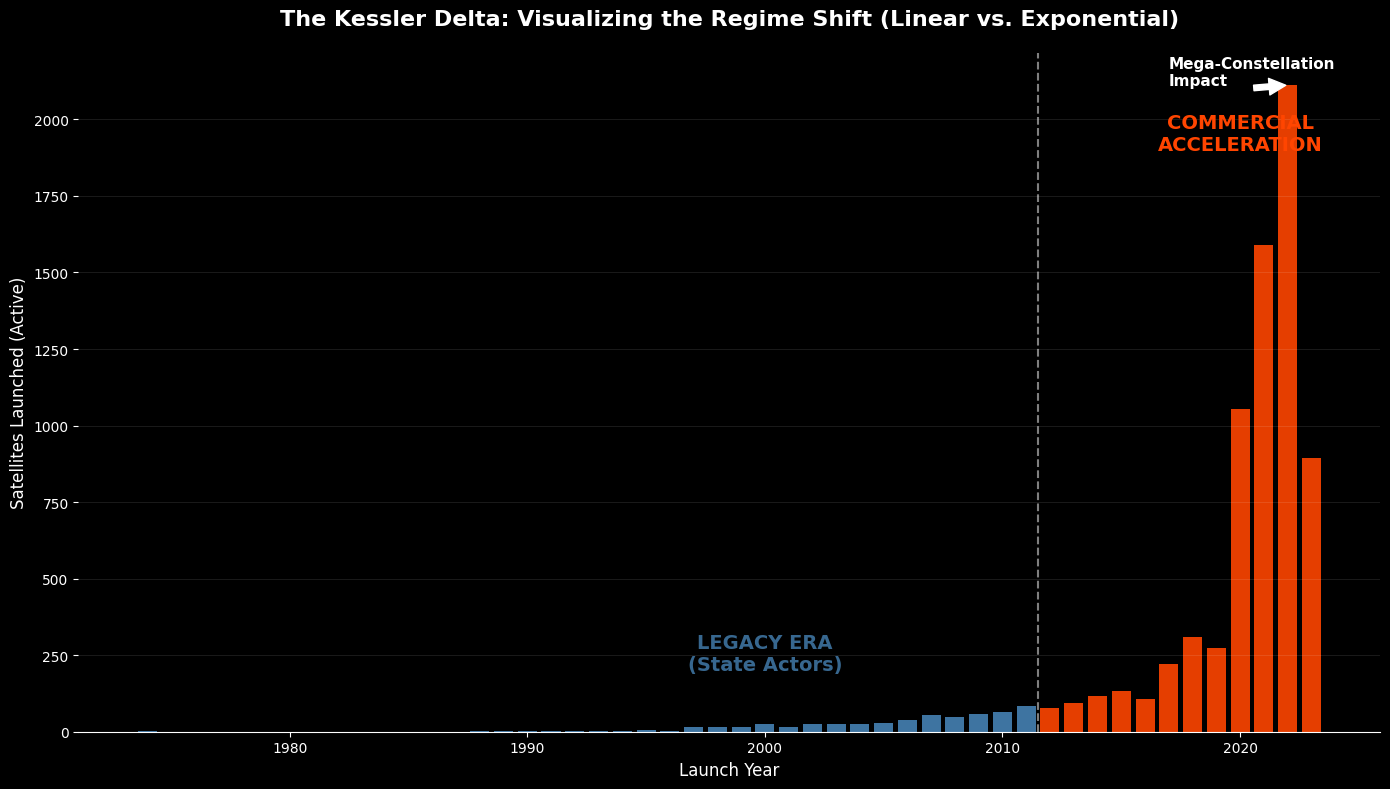

In [8]:

# Count Launches per Year
# We rely on the global 'launch_year' created in Section 1.2
launch_counts = ucs_cleaned['launch_year'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
plt.style.use('dark_background')

# "Split Point" (2012 is generally accepted as the start of New Space)
split_year = 2012

colors = ['#4682B4' if year < split_year else '#FF4500' for year in launch_counts.index]

bars = plt.bar(launch_counts.index, launch_counts.values, color=colors, alpha=0.9, width=0.8)

plt.text(2000, 200, "LEGACY ERA\n(State Actors)", color='#4682B4', fontsize=14, 
         ha='center', fontweight='bold', alpha=0.8)
plt.axvline(x=split_year - 0.5, color='white', linestyle='--', alpha=0.5)

plt.text(2020, launch_counts.max() * 0.9, "COMMERCIAL\nACCELERATION", color='#FF4500', fontsize=14, 
         ha='center', fontweight='bold')

max_year = launch_counts.idxmax()
max_val = launch_counts.max()
plt.annotate('Mega-Constellation\nImpact', xy=(max_year, max_val), xytext=(max_year-5, max_val),
             arrowprops=dict(facecolor='white', shrink=0.05),
             fontsize=11, color='white', fontweight='bold')

plt.title('The Kessler Delta: Visualizing the Regime Shift (Linear vs. Exponential)', 
          fontsize=16, color='white', fontweight='bold', pad=20)

plt.xlabel('Launch Year', fontsize=12, color='white')
plt.ylabel('Satellites Launched (Active)', fontsize=12, color='white')
plt.grid(axis='y', alpha=0.1)

sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.savefig('../images/temporal_regime_shift.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3.1: The Congestion Crisis (LEO vs. The Rest)
**The Objective:** Map the vertical distribution of the surge.

**The Insight:**
The exponential growth observed above is not uniform. It is almost exclusively contained within the **Low Earth Orbit (LEO)** regime. This creates a "shell of density" where collision probabilities skyrocket, while MEO and GEO remain relatively stable.

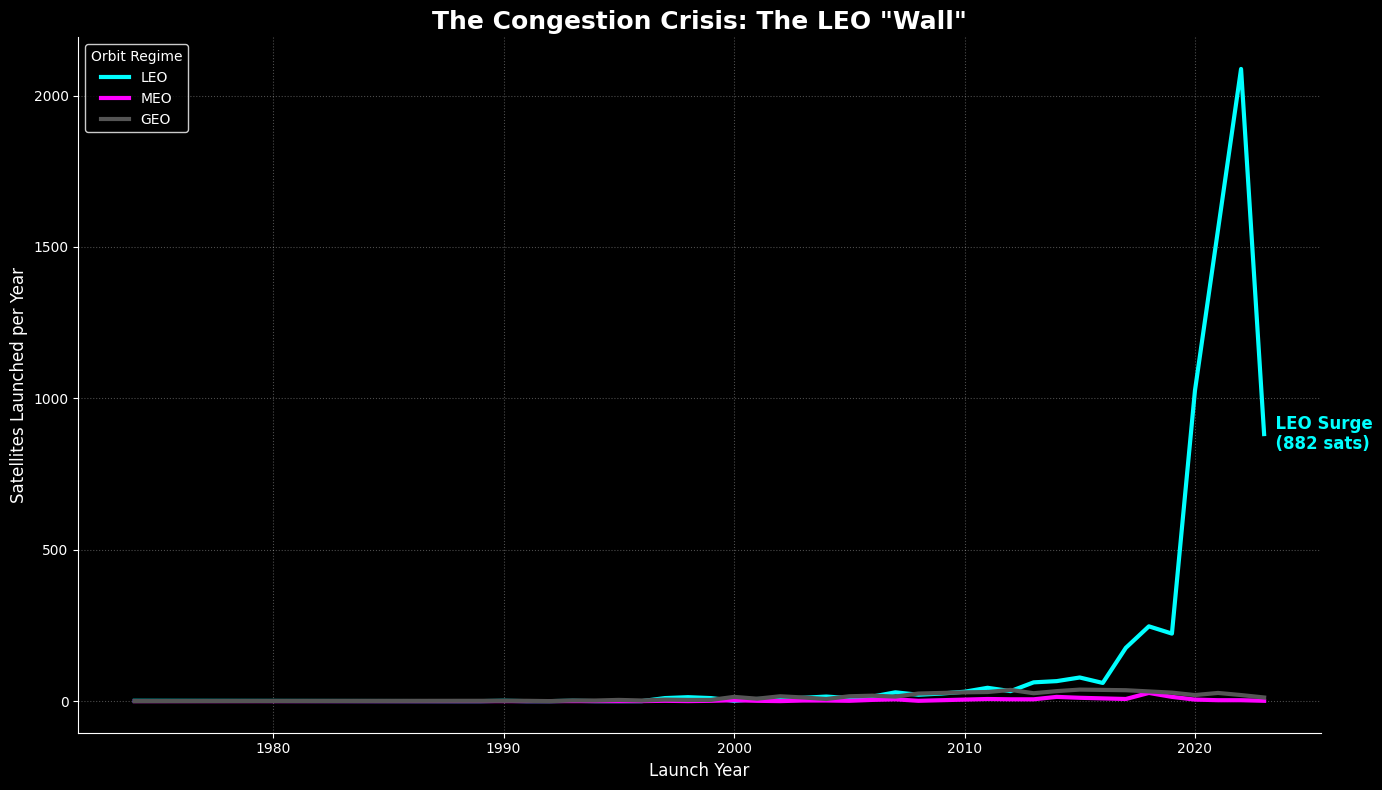

In [9]:
# Pivot the data to get counts per year per regime
orbit_evolution = ucs_cleaned.pivot_table(
    index='launch_year', 
    columns='orbit_regime', 
    values='norad_id', 
    aggfunc='count'
).fillna(0)

# Filter for the Big Three
target_orbits = orbit_evolution[['LEO', 'MEO', 'GEO']].copy()

plt.figure(figsize=(14, 8))
plt.style.use('dark_background')

custom_colors = ['cyan', 'magenta', '#555555'] 

sns.lineplot(data=target_orbits, palette=custom_colors, linewidth=3, dashes=False)

plt.title('The Congestion Crisis: The LEO "Wall"', fontsize=18, color='white', fontweight='bold')
plt.ylabel('Satellites Launched per Year', fontsize=12, color='white')
plt.xlabel('Launch Year', fontsize=12, color='white')

max_year = target_orbits.index.max()
max_leo_val = target_orbits['LEO'].iloc[-1]

plt.text(max_year, max_leo_val, f'  LEO Surge\n  ({int(max_leo_val)} sats)', 
         color='cyan', va='center', fontweight='bold', fontsize=12)

plt.grid(True, linestyle=':', alpha=0.3, color='white')
plt.legend(title='Orbit Regime', facecolor='black', edgecolor='white', labelcolor='white')
sns.despine()

plt.tight_layout()
plt.savefig('../images/orbit_congestion_leo.png', dpi=300, bbox_inches='tight')
plt.show()

### **Stage 4.0: Aggregating Launch Trends**
**The Problem:** To model growth dynamics effectively, we require a time-series dataset that represents the total number of satellite deployments per year. The raw registry exists as individual object entries rather than an annual count.

**The Solution:**
* **Leverage Pre-processing:** Utilize the `launch_year` feature established in the Data Pre-Processing stage.
* **Temporal Filtering:** Isolate the "Modern Era" (2000–2024) to focus the analysis on the "New Space" inflection point, removing Cold War-era noise.
* **Relational Aggregation:** Compress the registry into a `yearly_counts` dataframe ($X=$ Year, $Y=$ Volume) to serve as the clean input for mathematical modeling.

In [10]:
yearly_counts = ucs_cleaned.groupby('launch_year')['satellite_name'].nunique().reset_index()

modeling_data = yearly_counts[(yearly_counts['launch_year'] >= 2000) & 
                              (yearly_counts['launch_year'] <= 2024)]

x_data = modeling_data['launch_year'].values
y_data = modeling_data['satellite_name'].values

print(f"Modeling Dataset Ready: {len(x_data)} data points (2000-2024).")

Modeling Dataset Ready: 24 data points (2000-2024).


### **Stage 4.1: Defining Growth Models & Optimization**
**The Logic:** To quantify the transition in orbital dynamics, we fit two competing mathematical models to the observation data:
1. **Linear Model ($y = mx + b$):** Represents the "Steady State" legacy environment where growth was predictable and managed.
2. **Exponential Model ($y = a \cdot e^{b(x-c)}$):** Represents the "New Space" acceleration driven by commercial proliferation.

**The Method:**
We utilize non-linear least squares optimization (`curve_fit`) to lock the model parameters. Crucially, we also define the **Derivative Functions** (Slope) for both models. This allows us to mathematically identify the exact moment the *speed* of growth in the Exponential model overtook the fixed *speed* of the Linear model (The Pivot Point).

In [11]:
def linear_growth(x, m, b):
    return m * x + b

def exponential_growth(x, a, b, c):
    # np.clip prevents "overflow" errors during optimization
    exponent = np.clip(b * (x - c), None, 700)
    return a * np.exp(exponent)

# Define the derivative (slope) functions for later analysis
def exponential_slope(x, a, b, c):
    exponent = np.clip(b * (x - c), None, 700)
    return a * b * np.exp(exponent)

def slope_diff(x):
    return exponential_slope(x, *popt_exp) - linear_slope

# Prepare data (using aggregated yearly_counts)
modern_data = yearly_counts[yearly_counts['launch_year'] >= 2000].copy()
x_data = modern_data['launch_year'].values
y_data = modern_data['satellite_name'].values

# Perform the curve fit to generate popt_lin and popt_exp
try:
    # Linear fit
    popt_lin, _ = curve_fit(linear_growth, x_data, y_data)
    
    # Exponential fit with initial guesses
    initial_guess_exp = [10, 0.1, 2000]
    bounds_exp = ([0, 0, 1950], [1000, 1.0, 2024])
    popt_exp, _ = curve_fit(exponential_growth, x_data, y_data, p0=initial_guess_exp, bounds=bounds_exp)
    
    print("Optimization successful: 'popt_exp' and 'popt_lin' are now defined.")

    linear_slope = popt_lin[0]
    
    def slope_diff(x):
        return exponential_slope(x, *popt_exp) - linear_slope

except Exception as e:
    print(f"Fitting failed: {e}")

Optimization successful: 'popt_exp' and 'popt_lin' are now defined.


### **Stage 4.2: Model Divergence Audit**
**The Objective:** Visualize the separation between the "Legacy Prediction" and "Modern Reality."

**The Insight:**
By plotting both models over the same time horizon, we reveal the **"Risk Surplus"** — the number of satellites currently in orbit that *would not exist* if the industry had maintained its historical linear trajectory. This gap represents the unpredicted load on the orbital environment.

--- Model Divergence Audit ---
Year 2000 Gap: 305.7 satellites (Baseline)
Year 2024 Gap: 1,147.1 satellites (Risk Surplus)


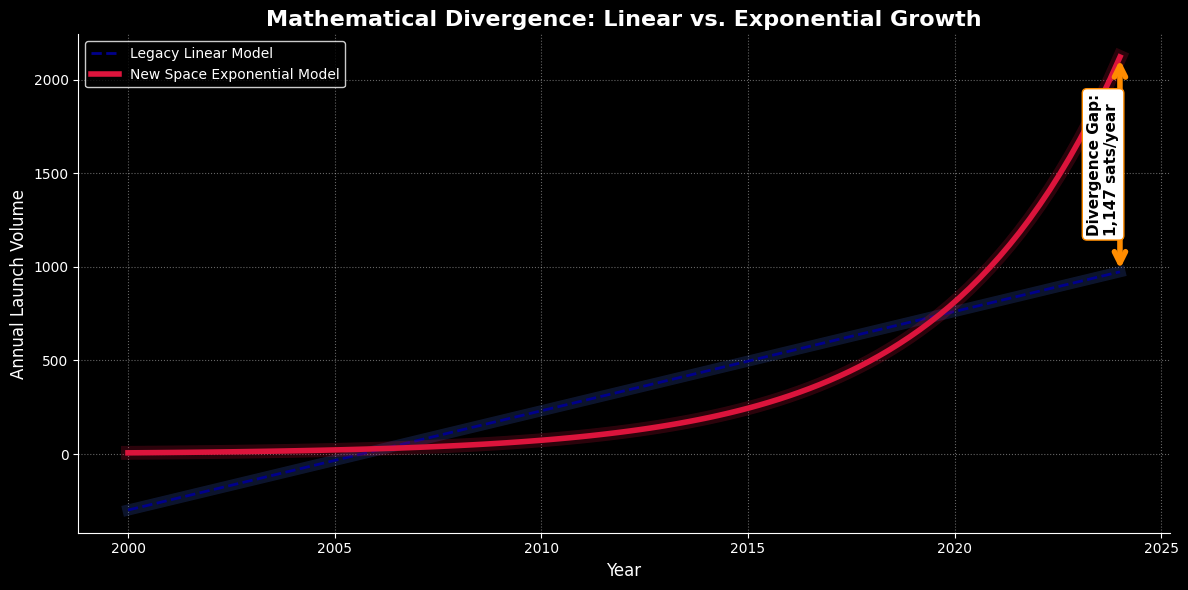

In [12]:
# Define the X-axis range
x_audit = np.linspace(2000, 2024, 100)

# We see where the models start (2000) and where they end (2024)
lin_2000, exp_2000 = linear_growth(2000, *popt_lin), exponential_growth(2000, *popt_exp)
lin_2024, exp_2024 = linear_growth(2024, *popt_lin), exponential_growth(2024, *popt_exp)

print(f"--- Model Divergence Audit ---")
print(f"Year 2000 Gap: {exp_2000 - lin_2000:,.1f} satellites (Baseline)")
print(f"Year 2024 Gap: {exp_2024 - lin_2024:,.1f} satellites (Risk Surplus)")

# Create the Visualization
plt.figure(figsize=(12, 6))

# Legacy Model (Blue Glow) - The "Safe" Path
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), color='royalblue', alpha=0.2, linewidth=8) 
plt.plot(x_audit, linear_growth(x_audit, *popt_lin), label='Legacy Linear Model', color='darkblue', linestyle='--', linewidth=2)

# New Space Model (Red Glow) - The "Current" Path
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), color='crimson', alpha=0.2, linewidth=10)
plt.plot(x_audit, exponential_growth(x_audit, *popt_exp), label='New Space Exponential Model', color='crimson', linewidth=4)

# Enhanced Divergence Gap (Orange Arrow)
plt.annotate('', xy=(2024, exp_2024), xytext=(2024, lin_2024),
             arrowprops=dict(arrowstyle='<->', color='darkorange', lw=4, mutation_scale=20))

# Divergence Gap
gap_value = exp_2024 - lin_2024
plt.text(2023.2, (exp_2024 + lin_2024)/2, f'Divergence Gap:\n{gap_value:,.0f} sats/year', 
         rotation=90, verticalalignment='center', fontweight='bold', fontsize=11, color='black',
         bbox=dict(facecolor='white', edgecolor='darkorange', boxstyle='round,pad=0.3'))

plt.title('Mathematical Divergence: Linear vs. Exponential Growth', fontsize=16, fontweight='bold', color='white')
plt.xlabel('Year', fontsize=12, color='white')
plt.ylabel('Annual Launch Volume', fontsize=12, color='white')
plt.grid(True, which='both', linestyle=':', alpha=0.4)
plt.legend(loc='upper left', frameon=True, facecolor='black', edgecolor='white', labelcolor='white')

sns.despine()
plt.tight_layout()

plt.savefig('../images/model_divergence_audit.png', dpi=300, bbox_inches='tight')
plt.show()

### **Stage 4.3: Identifying the Acceleration Point (Slope Analysis)**
**The Problem:** Because the "New Space" surge is so aggressive, the exponential model remained consistently above the linear legacy model for the duration of the search window (2000–2024). A simple intersection (where the lines cross) does not exist in this era.

**The Solution:** We shift our focus from **Volume** (where the lines cross) to **Velocity** (where the growth rates cross). By calculating the first derivative (the slope) of both models, we can identify the exact "Acceleration Point."

**The Logic:**
* **Linear Slope ($m$):** Represents the steady, historical cadence of legacy spaceflight.
* **Exponential Slope ($f'(x)$):** Represents the accelerating rate of deployments in the commercial era.
* **The Acceleration Point:** The specific year where the exponential growth rate officially became steeper than the legacy linear trend, signaling a fundamental regime shift in orbital density.

In [13]:
# Retrieve the linear velocity limit
linear_velocity = popt_lin[0]

# Solve for the Intersection
try:
    # brentq searches for the year (x) where slope_diff(x) == 0
    acceleration_year = brentq(slope_diff, 2000, 2024)
    
    # Calculate the volume at that exact decimal year for context
    sat_count_at_accel = exponential_growth(acceleration_year, *popt_exp)

    print(f"--- ACCELERATION EVENT IDENTIFIED ---")
    print(f"Exact Date (Decimal):  {acceleration_year:.4f}")
    print(f"Operational Volume:    {int(sat_count_at_accel)} satellites")
    print(f"Velocity Limit:        {linear_velocity:.2f} sats/year (Legacy Max)")
    print(f"Status:                LIMIT BROKEN")

except Exception as e:
    print(f"CRITICAL: Could not solve for acceleration point. {e}")

--- ACCELERATION EVENT IDENTIFIED ---
Exact Date (Decimal):  2014.5722
Operational Volume:    221 satellites
Velocity Limit:        53.02 sats/year (Legacy Max)
Status:                LIMIT BROKEN


### **Stage 4.3.1: Visualizing the Velocity Shift**
**The Insight:** The chart below visualizes the first derivative (Speed) of both models. The intersection point marks the exact moment the commercial industry began deploying satellites faster than historical legacy trends could predict.

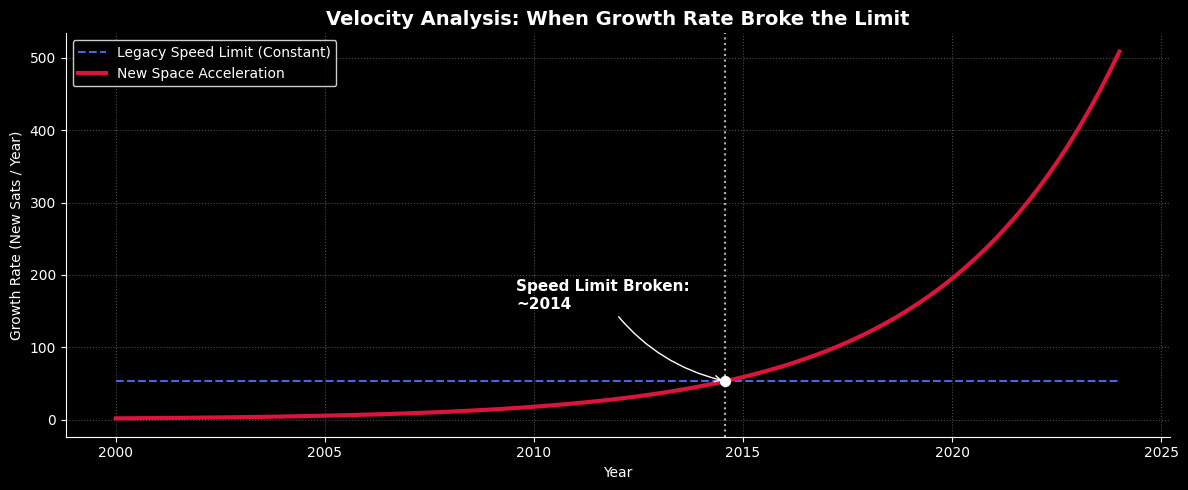

In [14]:
# Create the slope data
x_slope = np.linspace(2000, 2024, 100)

# 'linear_velocity' comes from the previous cell (Stage 4.3)
y_slope_lin = [linear_velocity] * 100 
y_slope_exp = [exponential_slope(x, *popt_exp) for x in x_slope]

plt.figure(figsize=(12, 5))

# Plot the Slopes (Velocity)
plt.plot(x_slope, y_slope_lin, label='Legacy Speed Limit (Constant)', color='royalblue', linestyle='--')
plt.plot(x_slope, y_slope_exp, label='New Space Acceleration', color='crimson', linewidth=3)

# Mark the Acceleration Point
# Changed Black -> White for visibility against Dark Background
plt.axvline(x=acceleration_year, color='white', linestyle=':', alpha=0.7)
plt.scatter([acceleration_year], [linear_velocity], color='white', zorder=5, s=50)

plt.title('Velocity Analysis: When Growth Rate Broke the Limit', fontsize=14, fontweight='bold', color='white')
plt.ylabel('Growth Rate (New Sats / Year)', color='white')
plt.xlabel('Year', color='white')

plt.annotate(f'Speed Limit Broken:\n~{int(acceleration_year)}', 
             xy=(acceleration_year, linear_velocity), 
             xytext=(acceleration_year - 5, linear_velocity + 100),
             arrowprops=dict(facecolor='white', edgecolor='white', arrowstyle='->', connectionstyle="arc3,rad=.2"),
             fontsize=11, color='white', fontweight='bold')

plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.grid(True, linestyle=':', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.savefig('../images/velocity_shift.png', dpi=300, bbox_inches='tight')
plt.show()

### **Stage 4.4: The Strategic Synthesis**
**The Visual Proof:** The chart below combines our observations and models into a single strategic picture.

**Key Elements:**
* **The Pivot:** The vertical line marks the calculated "Acceleration Year"—the moment the industry shifted gears.
* **The Risk Surplus:** The shaded magenta region represents the "Unplanned Mass"—satellites that exist solely because of the exponential shift, creating a debris burden the original orbital safety guidelines were never designed to handle.

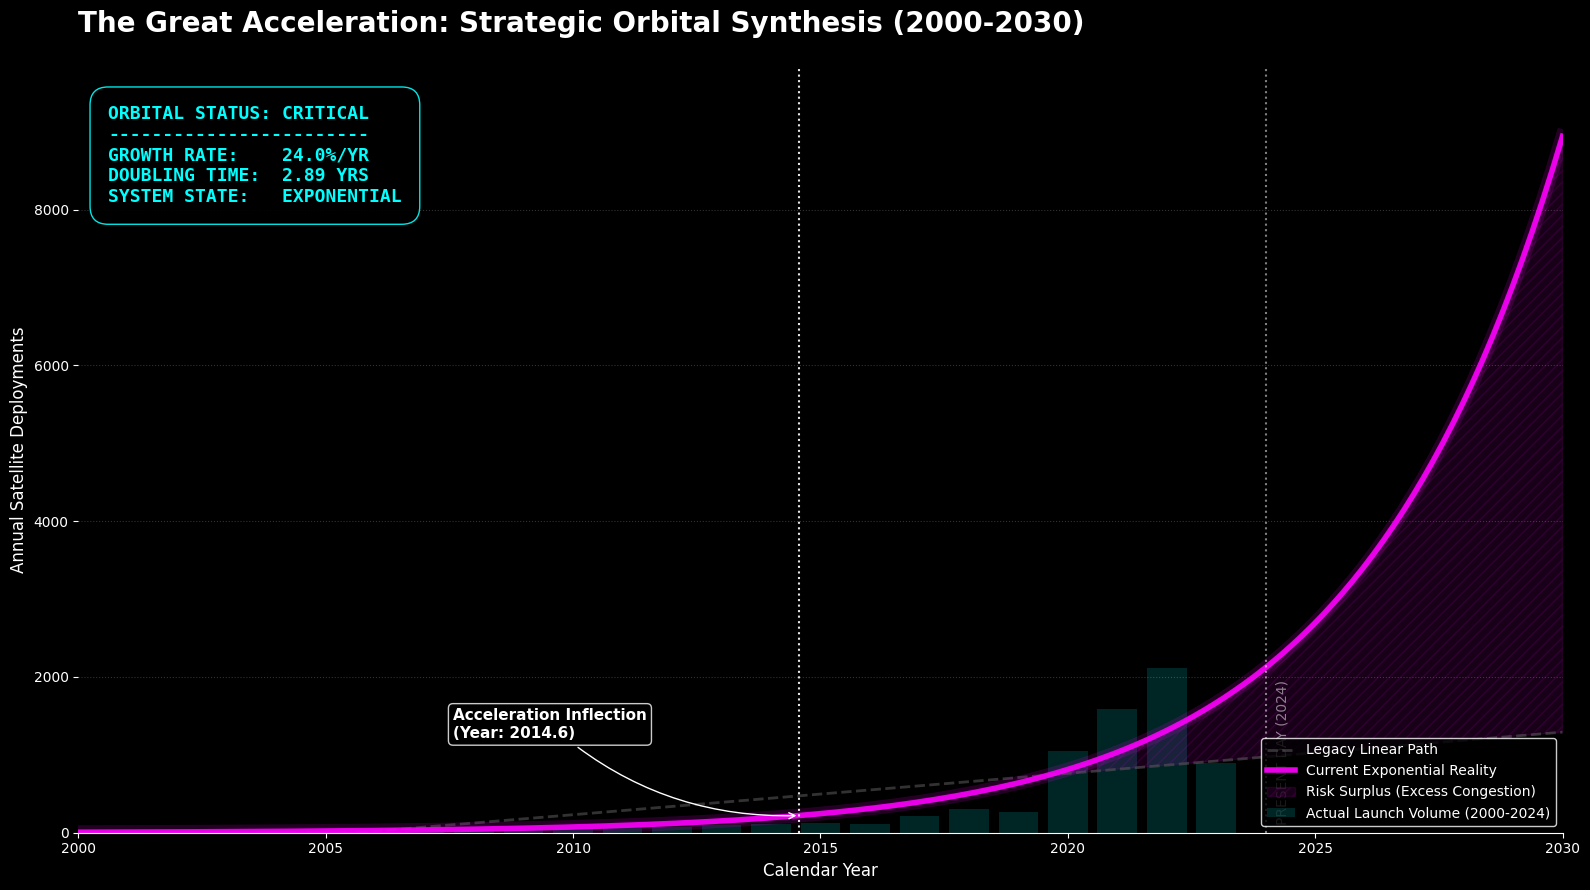

In [15]:
# Setup Timeline Projection (2000 to 2030)
x_proj = np.linspace(2000, 2030, 150)

# Compute Path Projections using fitted models
y_exp_path = exponential_growth(x_proj, *popt_exp)
y_lin_path = linear_growth(x_proj, *popt_lin)

# We calculate the exact values for 2024
y_exp_2024 = exponential_growth(2024, *popt_exp)
y_lin_2024 = linear_growth(2024, *popt_lin)

plt.figure(figsize=(16, 9))

# Historical Context: Actual Launch Volume (Bars)
plt.bar(yearly_counts['launch_year'], yearly_counts['satellite_name'], 
        color='cyan', alpha=0.15, label='Actual Launch Volume (2000-2024)', width=0.8)

# The Models: Legacy vs. Reality
plt.plot(x_proj, y_lin_path, color='#555555', linestyle='--', linewidth=2, label='Legacy Linear Path', alpha=0.6)
plt.plot(x_proj, y_exp_path, color='magenta', linewidth=4, label='Current Exponential Reality', alpha=0.9)
plt.plot(x_proj, y_exp_path, color='magenta', linewidth=10, alpha=0.15) # Outer Glow

# The Risk Surplus (The Danger Zone)
plt.fill_between(x_proj, y_lin_path, y_exp_path, where=(y_exp_path > y_lin_path), 
                 color='magenta', alpha=0.1, hatch='///', label='Risk Surplus (Excess Congestion)')

plt.axvline(x=acceleration_year, color='white', linestyle=':', alpha=0.9, linewidth=1.5)
plt.annotate(f'Acceleration Inflection\n(Year: {acceleration_year:.1f})', 
             xy=(acceleration_year, sat_count_at_accel), 
             xytext=(acceleration_year - 7, sat_count_at_accel + 1000),
             arrowprops=dict(facecolor='white', arrowstyle='->', connectionstyle="arc3,rad=.2"),
             fontsize=11, fontweight='bold', color='white', 
             bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3', alpha=0.8))

# The Kessler Clock
growth_rate = popt_exp[1]
doubling_time = np.log(2) / growth_rate

ax = plt.gca()
hud_content = (
    f"ORBITAL STATUS: CRITICAL\n"
    f"------------------------\n"
    f"GROWTH RATE:    {growth_rate:.1%}/YR\n"
    f"DOUBLING TIME:  {doubling_time:.2f} YRS\n"
    f"SYSTEM STATE:   EXPONENTIAL"
)

ax.text(0.02, 0.95, hud_content, transform=ax.transAxes, fontsize=13, 
        color='cyan', family='monospace', fontweight='bold',
        va='top', ha='left',
        bbox=dict(facecolor='black', edgecolor='cyan', boxstyle='round,pad=1', alpha=0.9))

# 2024 Marker
plt.axvline(x=2024, color='white', linestyle=':', alpha=0.5)
plt.text(2024.2, 100, "PRESENT DAY (2024)", color='white', rotation=90, verticalalignment='bottom', alpha=0.5)

plt.title('The Great Acceleration: Strategic Orbital Synthesis (2000-2030)', 
          fontsize=20, color='white', fontweight='bold', loc='left', pad=25)
plt.ylabel('Annual Satellite Deployments', fontsize=12, color='white')
plt.xlabel('Calendar Year', fontsize=12, color='white')
plt.xlim(2000, 2030)
plt.ylim(0, y_exp_path.max() * 1.1)
plt.grid(axis='y', linestyle=':', alpha=0.2)
plt.legend(loc='lower right', facecolor='black', edgecolor='white', labelcolor='white')

sns.despine(left=True)
plt.tight_layout()
plt.savefig('../images/great_acceleration.png', dpi=300, bbox_inches='tight')
plt.show()

### **Stage 4.5: Tactical Metric Audit**

**The Quantitative Delta:** This audit translates our mathematical modeling into hard operational figures. By isolating the **2024 Event Horizon**, we quantify the "Risk Surplus" — the specific number of satellites launched annually that exceed legacy structural expectations. These figures represent the **active kinetic load** that the orbital environment must now absorb, operating far beyond the design limits of original debris mitigation guidelines.

In [16]:
print(f"{'Metric':<35} | {'Value':<25}")
print("-" * 65)
print(f"{'Acceleration Event (Year)':<35} | {int(acceleration_year)}")
print(f"{'Velocity at Break-Point':<35} | {int(sat_count_at_accel)} sats/year")
print(f"{'Current Output (2024)':<35} | {int(y_exp_2024)} sats/year")
print(f"{'Risk Surplus (Excess Burden)':<35} | {int(y_exp_2024 - y_lin_2024)} satellites")

Metric                              | Value                    
-----------------------------------------------------------------
Acceleration Event (Year)           | 2014
Velocity at Break-Point             | 221 sats/year
Current Output (2024)               | 2120 sats/year
Risk Surplus (Excess Burden)        | 1147 satellites


Conclusion: Active Environment Characterization
===============================================

**Status:** Phase 1 (Active Inventory Analysis) — **COMPLETE**

### **Key Intelligence Findings:**

1.  **The Inflection Point:** Mathematical modeling confirms a fundamental regime shift where the orbital environment decoupled from legacy linear growth. The "New Space" acceleration reached its critical pivot point in approximately **2014-2015**.
2.  **Kinetic Velocity:** The current exponential trajectory is producing a population doubling time of less than **3 years** (as calculated in Section 4.5). This launch cadence creates a "Velocity Gap" that outpaces current regulatory and mitigation frameworks.
3.  **Orbital Bottleneck:** Kinetic risk is not universally distributed; it is acutely concentrated within the **LEO Shell (500-600km)**, creating a high-density corridor where the probability of collision is statistically highest.

### **Next Phase: The Invisible Population**

We have successfully quantified the _Active_ environment. However, operational assets represent only a small fraction of the total kinetic threat in orbit.

In the next module, **satcat_cleanup.ipynb**, we will transition from the Active Registry to the **Master Satellite Catalog (SATCAT)**. We will process the full historical registry of ~60,000 objects to map the "Graveyard Orbit"—uncovering the dead payloads, spent rocket bodies, and fragmentation debris lurking in the darkness.